# Notebook 1: Data Processing

## TOC:
* [Data Preparation](#data_preparation)
    * [Positive data](#positive_data)
        * [Step 1: Obtain necessary data from chart dataset](#positive_step_1)
        * [Step 2: Obtain lyrics from lyrics dataset](#positive_step_2)
    * [Negative data](#negative_data)
        * [Step 1: Randonly sample from lyrics dataset](#negative_step_1)
        * [Step 2: Get song url with spotify API](#negative_step_2)
    * [Get features for both positive and negative samples](#get_features_all)
        * [Step 1: Declare necessary functions](#declare_necessary)
        * [Step 2: Get features for positive samples](#get_positive_features)
        * [Step 3: Get features for negative samples](#get_negative_features)
    * [Merging positive and negative samples](#merge_all)
        * [Step 1: Tag positive and negative samples](#merge_step_1)
        * [Step 2: Merge together](#merge_step_2)
    * [Further processing of data](#further_processing)


### Import necessary library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials 
import time
from difflib import SequenceMatcher
client_id = "YOUR_CLIENT_ID"
client_secret = "YOUR_CLIENT_SECRET"

C:\Users\tiany\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tiany\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\tiany\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Data Preparation <a name="data_preparation"> </a>
---

Our goal is to develop a model to perform classification on song to determine if it will be trending. 

We therefore required both trending (positive) and non-trending (negative) dataset by utilizing `2` datasets `chart.csv` with data of trending songs and `ds2.csv` with lyrics data from genius.com. We will also leverage the `Spotify developer web API` to get additional features to better represent different songs.

---


Firstly, we will obtain **data for popular song**, which we call `positive data`

## Positive data <a name="positive_data"> </a>
---
Steps for preparing necessary positive data are as follow:

1. [filter and process kaggle chart data to obtain basic information of a song (title, artist, url, number of days on trend, year)](#positive_step_1)
2. [merge chart dataset with lyrics dataset to obtain lyrics for each song](#positive_step_2)

### Step 1: Obtain necessary information from chart dataset <a name="positive_step_1"> </a>


The substeps are as follow:
- 1.1. [Read chart data](#read_chart_data)
- 1.2. [Filter data](#filter_data)
- 1.3. [Extract necessary features](#extract_necessary_features)


#### Our dataset: Kaggle Spotify chart data -- "chart.csv"


Ref: https://www.kaggle.com/datasets/dhruvildave/spotify-charts

This `chart.csv` dataset is found on Kaggle. 

This Spotify chart dataset is 3.48GB a dataset with 26173514 rows of data, describing the change of trending status of various songs on top200 or viral 50 chart from 2017 to 2021.

There are 9 columns in this dataset:

|feature name|description|value|
|---------------|---------------|---------------|
|title|Title of the song|String|
|rank|Rank from 1 - 200 (1 is the most streamed track of the day)| Integer|
|date|Date of data|String|
|artist|Artist name|String|
|url|url of the song|String|
|region|countries around the world|String|
|chart|top200 chart or viral50 chart|String|
|trend|Position of that song on the chart compared to the day before.<br>It has 3 values: {MOVE_UP, MOVE_DOWN, SAME_POSITION}|String|
|streams|Total number of global streams of that song in one day|Integer|


#### Step 1.1: Read chart data <a name = "read_chart_data"> </a>

In [2]:
#read spotify chart dataset
df_chart = pd.read_csv('charts.csv')
df_chart

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0
...,...,...,...,...,...,...,...,...,...
26173509,BYE,46,2021-07-31,Jaden,https://open.spotify.com/track/3OUyyDN7EZrL7i0...,Vietnam,viral50,MOVE_UP,NaN
26173510,Pillars,47,2021-07-31,My Anh,https://open.spotify.com/track/6eky30oFiQbHUAT...,Vietnam,viral50,NEW_ENTRY,NaN
26173511,Gái Độc Thân,48,2021-07-31,Tlinh,https://open.spotify.com/track/2klsSb2iTfgDh95...,Vietnam,viral50,MOVE_DOWN,NaN
26173512,Renegade (feat. Taylor Swift),49,2021-07-31,Big Red Machine,https://open.spotify.com/track/1aU1wpYBSpP0M6I...,Vietnam,viral50,MOVE_DOWN,NaN


The data in the `chart.csv` is in a form of **time-series data**. However, our goal is **not** to perform prediction or generate insight according to time, but to perform **classification regarding the features of a song itself**. Hence, we will need to further process this dataset and obtain the necessary information. 

#### Step 1.2: Filter data <a name = "filter_data"> </a>


##### Explore region data
Stream refers to the total number of global streams of a song in one day. 

By group the region and stream columns of the dataset, we would like to find out the proportion of streams different songs that are trending in different regions. 

In [4]:
# compute total streams by region
stream = df_chart.groupby('region')['streams'].sum().reset_index()

# compute percent stream
stream['percent_streams'] = stream['streams']/stream['streams'].sum()

# group region with very small percentage (< .01 %) as 'Other'
stream['region'] = stream.apply(lambda x: x['region'] if x['percent_streams'] >= .01 else 'Other', axis=1)

# groupby to handle multiple 'Other' regions that are being created
stream = stream.groupby('region')['percent_streams'].sum().reset_index().round(3).sort_values(by='percent_streams')

stream


,region,percent_streams
16,Turkey,0.011
15,Sweden,0.013
8,Indonesia,0.014
4,Chile,0.015
0,Argentina,0.017
3,Canada,0.017
13,Philippines,0.017
11,Netherlands,0.017
1,Australia,0.018
5,France,0.021


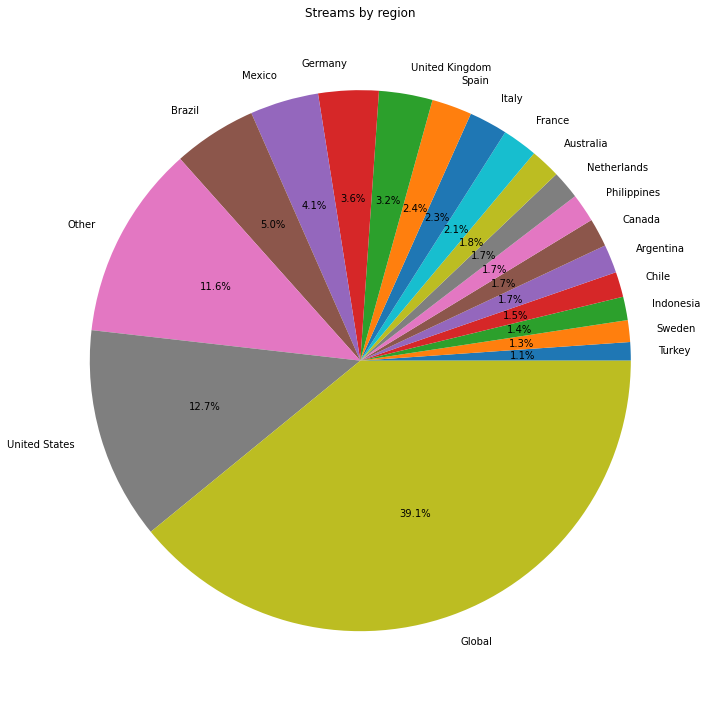

In [5]:
#Plot pie chart or region stream percentage
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(x=stream['percent_streams'], labels=stream['region'], autopct='%.1f%%')
ax.set_title('Streams by region')
plt.tight_layout()


From the pie chart, we could see that `Global` has the **highest proportion**, which indicate songs that are trending globally has the most views. Thus, Global could also be considered as the **most representative** data as it incorpate data from all parts of the world. 

Therefore, we decided only process data with region as `Global`.

##### filter data

In [8]:
# filter df_chart to df_global so df_global are all global data
df_global = df_chart.copy()
df_global = df_global[(df_global['region'] == 'Global')]
df_global

,title,rank,date,artist,url,region,chart,trend,streams
3234,Starboy,1,2017-01-01,"The Weeknd, Daft Punk",https://open.spotify.com/track/5aAx2yezTd8zXrk...,Global,top200,SAME_POSITION,3135625.0
3235,Closer,2,2017-01-01,"The Chainsmokers, Halsey",https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,Global,top200,SAME_POSITION,3015525.0
3236,Let Me Love You,3,2017-01-01,"DJ Snake, Justin Bieber",https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,Global,top200,MOVE_UP,2545384.0
3237,Rockabye (feat. Sean Paul & Anne-Marie),4,2017-01-01,Clean Bandit,https://open.spotify.com/track/5knuzwU65gJK7IF...,Global,top200,MOVE_DOWN,2356604.0
3238,One Dance,5,2017-01-01,"Drake, WizKid, Kyla",https://open.spotify.com/track/1xznGGDReH1oQq0...,Global,top200,SAME_POSITION,2259887.0
...,...,...,...,...,...,...,...,...,...
26171166,Shake It,46,2021-07-31,INNDRIVE,https://open.spotify.com/track/5otdjL2CJnNLbY3...,Global,viral50,SAME_POSITION,NaN
26171167,Ain't Shit,47,2021-07-31,Doja Cat,https://open.spotify.com/track/5lAnYvAIkSDNXqf...,Global,viral50,SAME_POSITION,NaN
26171168,Ride the Lightning - 717 Tapes,48,2021-07-31,Warren Zeiders,https://open.spotify.com/track/1JTQG8J8jN8tjDT...,Global,viral50,MOVE_UP,NaN
26171169,Feels Like Summer,49,2021-07-31,Samuel Jack,https://open.spotify.com/track/0VJXYUuvJAg4NdZ...,Global,viral50,MOVE_DOWN,NaN


--Finish fitering data--

#### Step 1.3: Extract necessary features from current data <a name = "extract_necessary_features"> </a>


There are a few extra features we would want to derived from the current dataset

- `Year`: The year of the first occurance of a song being trending
- `Number of days`: The number of days a song remain on any of the charts throughout the whole time

We extract features by processing the time-series data `date` to different form of numeric data `year` and `number of days`

Step required:

* 1.3.A. [Extract year from date](#extract_year_from_date)
* 1.3.B. [Count number of days](#count_number_of_days)
* 1.3.C. [Get sum of days](#get_sum_of_days)

##### Step 1.3.A: Extract year from date <a name = "extract_year_from_date> </a>

In [9]:
# Extract year from date
df_global.insert(3,"Year",df_global['date'].str[:4])
df_global.head()

,title,rank,date,Year,artist,url,region,chart,trend,streams
3234,Starboy,1,2017-01-01,2017,"The Weeknd, Daft Punk",https://open.spotify.com/track/5aAx2yezTd8zXrk...,Global,top200,SAME_POSITION,3135625.0
3235,Closer,2,2017-01-01,2017,"The Chainsmokers, Halsey",https://open.spotify.com/track/7BKLCZ1jbUBVqRi...,Global,top200,SAME_POSITION,3015525.0
3236,Let Me Love You,3,2017-01-01,2017,"DJ Snake, Justin Bieber",https://open.spotify.com/track/4pdPtRcBmOSQDlJ...,Global,top200,MOVE_UP,2545384.0
3237,Rockabye (feat. Sean Paul & Anne-Marie),4,2017-01-01,2017,Clean Bandit,https://open.spotify.com/track/5knuzwU65gJK7IF...,Global,top200,MOVE_DOWN,2356604.0
3238,One Dance,5,2017-01-01,2017,"Drake, WizKid, Kyla",https://open.spotify.com/track/1xznGGDReH1oQq0...,Global,top200,SAME_POSITION,2259887.0


##### Step 1.3.B: Count number of days a song is trending while keeping the necessary year value <a name = "count_number_of_days"> </a>

To get the count of number of days, we will need group songs data together. 

We noticed that there will be duplicated songs data in different years. If we simply use `title` or `artist` or `url` as the unique key to group song data together, we will not be able to get the `year` data (first year of a song being trending). 


See row 3 and 4, both are uicideboy's song "...And To Those I Love, Thanks For Sticking Ar..." with same  `artist`, `title` and `url` value but differnet `Year` value.


Hence, we will first perform grouping with `artist`, `title`, `url`, `Year` and count the number of days a song is trending per year. 


In [14]:
df_global_new = df_global.groupby(['artist', 'title','url','Year'])['date'].count().reset_index()
df_global_new.columns = ['artist', 'title','url','Year', 'Number of days']
df_global_new.head()


,artist,title,url,Year,Number of days
0,"$hirak, Ronnie Flex, Yssi SB, Lil Kleine",UHUH,https://open.spotify.com/track/5feza64dOl5JSSi...,2021,7
1,$ilkMoney,My Potna Dem,https://open.spotify.com/track/7uWdDOhI3wydISW...,2021,39
2,"$kyhook, Morad",A Escondidas,https://open.spotify.com/track/7754vHc34U2wQMI...,2019,27
3,$uicideboy$,"...And To Those I Love, Thanks For Sticking Ar...",https://open.spotify.com/track/41LhQUkElADQ5YU...,2020,8
4,$uicideboy$,"...And to Those I Love, Thanks for Sticking Ar...",https://open.spotify.com/track/30QR0ndUdiiMQMA...,2021,50


##### Step 1.3.C: get the sum of days of a song across different year and keep the minimum year value <a name = "get_sum_of_days"> </a>

After counting per year, we could then use `.agg` to get `Number of days` (the sum of all count values over the year of songs), while retrieving the `year`(first occurance on trend) values.

In [12]:
# use the unique url as key
df_grouped = df_global_new.groupby(['url']).agg({'artist':'first','title':'first', 'Number of days': 'sum', 'Year': 'min'}).reset_index()
df_grouped.head()


,url,artist,title,Number of days,Year
0,https://open.spotify.com/track/000xQL6tZNLJzIr...,ZAYN,Still Got Time (feat. PARTYNEXTDOOR),125,2017
1,https://open.spotify.com/track/003VDDA7J3Xb2ZF...,"Trippie Redd, Young Thug",YELL OH,2,2020
2,https://open.spotify.com/track/003eoIwxETJujVW...,Alessia Cara,Growing Pains,21,2018
3,https://open.spotify.com/track/003vvx7Niy0yvhv...,The Killers,Mr. Brightside,268,2020
4,https://open.spotify.com/track/00B7TZ0Xawar6NZ...,Cardi B,Best Life (feat. Chance The Rapper),22,2018


In [15]:
#check if there is still any duplicated entries
print(len(df_grouped['url'].unique()), len(df_grouped))


12528 12528


In [16]:
#rearrange columns
df_grouped = df_grouped[['artist', 'title', 'url', 'Number of days', 'Year']]


-- finish getting new features --

---
#### Positive data after processing chart dataset

|feature name|description|value|
|---------------|---------------|---------------|
|artist|Artist name|String|
|title|Title of the song|String|
|url|url of the song|String|
|Number of days|Sum of number of days of a song being trending on any chart globally|Integer|
|Year|The year when this song being trending for the first time|Integer|

In [23]:
df_grouped

,artist,title,url,Number of days,Year
0,ZAYN,Still Got Time (feat. PARTYNEXTDOOR),https://open.spotify.com/track/000xQL6tZNLJzIr...,125,2017
1,"Trippie Redd, Young Thug",YELL OH,https://open.spotify.com/track/003VDDA7J3Xb2ZF...,2,2020
2,Alessia Cara,Growing Pains,https://open.spotify.com/track/003eoIwxETJujVW...,21,2018
3,The Killers,Mr. Brightside,https://open.spotify.com/track/003vvx7Niy0yvhv...,268,2020
4,Cardi B,Best Life (feat. Chance The Rapper),https://open.spotify.com/track/00B7TZ0Xawar6NZ...,22,2018
...,...,...,...,...,...
12523,The Carters,SUMMER,https://open.spotify.com/track/7zmleW3XZx0uUsL...,7,2018
12524,Yüzyüzeyken Konuşuruz,Ölsem Yeridir,https://open.spotify.com/track/7zn6VQuPR6aCLPR...,11,2019
12525,Trippie Redd,Be Yourself,https://open.spotify.com/track/7znO2T2deQ7nZUb...,1,2019
12526,David Byrne,Everybody's Coming To My House,https://open.spotify.com/track/7zuLFva2TbSg6mB...,5,2018


---

### Step 2: Obtain lyrics by merging with lyrics dataset <a name="positive_step_2"> </a>

#### Our dataset: lyrics dataset -- "ds3.csv"

Ref: https://www.kaggle.com/datasets/nikhilnayak123/5-million-song-lyrics-dataset

The 'lyrics.csv' dataset is found on Kaggle. 

This '5 Million Song Lyrics Dataset' dataset is 9.21GB a dataset with 5913411 rows of data, providing basic information such as title, view count and lyrics of all the songs from genius.com (a lyrics website). Its data include those unpopular/non-trending song as it solely based on the lyrics database.

There are 8 columns in this dataset:

|feature name|description|value|
|---------------|---------------|---------------|
|title|Title of the song|String|
|tag|genre of song as a categorical variable|String|
|artist|Artist name|String|
|year|Song's release date|Integer|
|views|view on genius.com|Integer|
|features|feature of the song such as artist name|String|
|lyrics|lyrics of song|String|
|id|id on the song on genius.com|Integer|


#### Read lyrics data

In [20]:
# read lyrics dataset
df_lyrics = pd.read_csv('ds3.csv')
df_lyrics1 = df_lyrics.copy()
df_lyrics.head()

,title,tag,artist,year,views,features,lyrics,id
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6


#### Merge positive dataset with lyrics dataset

we realised that the naming method of `artist` and `title` in chart dataset and lyrics dataset is a bit different. For example, only the first character of each word in `title` in lyrics dataset is capitalized, while the whole word might be capitalized in chart dataset.

Therefore, extra care needs to be taken when merging the two datasets.

Steps taken as as follow:

- 2.1 [declare a function to facilitate the transformation of string data for merging](#step2.1)
- 2.2. [perform careful cleaning](#step2.2)
    - 2.2.A. [check any duplicated merge as some song name and artist might the same](#step2.2.a)
    - 2.2.B. [handle merged data to remove unwanted entries](#step2.2.b)
    - 2.2.C. [check again if all duplicated values are dropped](#step2.2.c)


In [26]:
# create a copy of df_grouped just in case
df_grouped1 = df_grouped.copy()
df_grouped1

,artist,title,url,Number of days,Year
0,ZAYN,Still Got Time (feat. PARTYNEXTDOOR),https://open.spotify.com/track/000xQL6tZNLJzIr...,125,2017
1,"Trippie Redd, Young Thug",YELL OH,https://open.spotify.com/track/003VDDA7J3Xb2ZF...,2,2020
2,Alessia Cara,Growing Pains,https://open.spotify.com/track/003eoIwxETJujVW...,21,2018
3,The Killers,Mr. Brightside,https://open.spotify.com/track/003vvx7Niy0yvhv...,268,2020
4,Cardi B,Best Life (feat. Chance The Rapper),https://open.spotify.com/track/00B7TZ0Xawar6NZ...,22,2018
...,...,...,...,...,...
12523,The Carters,SUMMER,https://open.spotify.com/track/7zmleW3XZx0uUsL...,7,2018
12524,Yüzyüzeyken Konuşuruz,Ölsem Yeridir,https://open.spotify.com/track/7zn6VQuPR6aCLPR...,11,2019
12525,Trippie Redd,Be Yourself,https://open.spotify.com/track/7znO2T2deQ7nZUb...,1,2019
12526,David Byrne,Everybody's Coming To My House,https://open.spotify.com/track/7zuLFva2TbSg6mB...,5,2018


##### Step 2.1: declare a function to merge the two datasets <a name = "step2.1"> </a>
merge_song(df, df_song) will perform **inner merge** on two dataset by comparing goth their artist and title string

In [24]:
def merge_song(df, df_song):
    df['artist'] = df['artist'].str.split(',')
    df = df.explode('artist')
    df_song['artist'] = df_song['artist'].str.split(',')
    df_song = df_song.explode('artist')
    df['artist'] = df['artist'].apply(lambda x: x.strip())
    df_song['artist'] = df_song['artist'].apply(lambda x: x.strip())
    df['title'] = df['title'].str.lower()
    df['title'] = df['title'].astype(str)
    df_song['title'] = df_song['title'].str.lower()
    df_song['title'] = df_song['title'].astype(str)
    df['artist'] = df['artist'].str.lower()
    df['artist'] = df['artist'].astype(str)
    df_song['artist'] = df_song['artist'].str.lower()
    df_song['artist'] = df_song['artist'].astype(str)
    df_merged = pd.merge(df, df_song, how='inner', left_on=['title','artist'], right_on = ['title','artist'])
    return df_merged

In [28]:
df_positive_merged = merge_song(df_lyrics1, df_grouped1)

In [29]:
df_positive_merged

,title,tag,artist,year,views,features,lyrics,id,url,Number of days,Year
0,stronger,rap,kanye west,2007,1438598,{},"[Produced by Kanye West, Mike Dean, and Timbal...",525,https://open.spotify.com/track/6C7RJEIUDqKkJRZ...,7,2017
1,the real slim shady,rap,eminem,2000,2926565,{},"[Intro]\nMay I have your attention, please?\nM...",531,https://open.spotify.com/track/3yfqSUWxFvZELEM...,205,2021
2,paris morton music,rap,drake,2010,473576,{},"[Chorus]\nWould've came back for you, I just n...",776,https://open.spotify.com/track/73IE87H0g2MBmdn...,1,2019
3,without me,rap,eminem,2002,3212844,{},"[Intro: Obie Trice]\nObie Trice, real name, no...",811,https://open.spotify.com/track/7lQ8MOhq6IN2w8E...,86,2017
4,keep ya head up,rap,2pac,1993,1712247,{},[Intro: 2Pac]\nLittle something for my godson ...,826,https://open.spotify.com/track/0XRbYXQUymj9SJk...,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
6784,everyday,rap,logic,2018,21,{Marshmello},"Yeah, ayy\nI work hard every motherfuckin' day...",7811784,https://open.spotify.com/track/4EAV2cKiqKP5UPZ...,129,2018
6785,everyday,rap,logic,2018,21,{Marshmello},"Yeah, ayy\nI work hard every motherfuckin' day...",7811784,https://open.spotify.com/track/6zOhgKfbMiQWToE...,11,2018
6786,sahara,rap,hensonn,2021,133,{},[Instrumental],7814578,https://open.spotify.com/track/6nqdgUTiWt4JbAB...,10,2021
6787,mendung tanpo udan,pop,ndarboy genk,2022,28,{},[Intro]\nMendung tanpo udan\nKetemu lan kelang...,7822659,https://open.spotify.com/track/0Z54rUZ81Vn0qph...,12,2021


successfully match around 6500 songs from the two datasets

##### Step 2.2: explore the mereged dataframe and see if any cleaning needs to be done <a name = "step2.2"> </a>

I): check and see if there's any duplicated merge as some song name and artist might the same <a name = "step2.2.a"> </a>

In [37]:
df_positive_merged.duplicated(subset=['lyrics']).sum()

1142

In [50]:
duplicated_count = pd.DataFrame(df_positive_merged[df_positive_merged.duplicated(subset=['lyrics'])]['lyrics'].value_counts())
duplicated_count.head()

,lyrics
[Instrumental],44
"Black eyed peas - MAMACITA - текст песни\n\nBaby, ven conmigo (Ven conmigo; oh-oh)\nBaila (Baila)\nLa música e' testigo, ya la veo, mamacita (-ta)\nLouis Vuitton en su vestido (Su vestido)\nDiamante, le gusta cuando al oído yo le digo, eh-eh\nMamacita, mamacita\nQué bonita, mamacita\nEh-oh-oh-oh\nEh-oh-oh-oh\nMamacita, mamacita\nQué bonita, mamacita\nElla no le baja, nunca tumba (Nunca tumba)\nSiempre anda lista pa' la rumba (Pa' la rumba)\nDo' amiga' que le secundan (Oh-oh)\nSalen y gastan la funda (Ey)\nLe gusta sudar el alcohol (Sudar el—)\nSola la pasa' mejor (Pasa')\nVestía' de Christian Dior\nSiempre llega cuando sale el sol\nDame de lo que yo sé, eh-\nUna botella 'e Rosé\nQue la shorty tiene sed\nEse booty, mami, la rompe\nElla tiene algo que hace que a mí me guste\nElla tiene algo que hace que a mí me guste\nIm'a put you in the mix, put you in the mix\nPut you in the, put you in the put you in the mix, eh\nAlright, okay\nI'ma love you all kinda ways\nBut you got me caliente\nWhen you call me ""mamacita""\nAlright, uh-huh\nOh, you got me sayin', ""Ooh-la-la""\nAy, Dios mío, oh my God\nCall me ""mamacita""\nMamacita, mamacita\nQué bonita, mamacita\nEh-oh-oh-oh\nEh-oh-oh-oh\nDame eso, dame beso\nDame tu corazón, dame cuerpo\nMami, when you get me body I'm won't let go\nYou're the best, baby, yup, you special\nDamn, baby, I want what you got\nFirst time I seen you, I'm like, ""Who that?""\nDame dulce, dame azúcar\nI do what you say, vamos a bailar\n'Cause I like the way you move, like this (Eh)\nI like the way you wind up your hips (Eh)\nI like the way you grind and twist it (Eh)\nHot damn, baby, you got me lit\nWhen you put me in the mix (Ah), put me in the mix (Ah)\nPut me in the, put me in the, put me in the mix\nI'ma put you in the mix, put you in the mix\nPut you in the, put you in the put you in the mix, eh\nAlright, okay\nI'ma love you all kinda ways\nBoy, you got me caliente\nWhen you call me ""mamacita""\nAlright, uh-huh\nBoy, you got me sayin', ""Ooh-la-la""\nAy, Dios mío, oh my God\nCall me ""mamacita""\nMamacita, mamacita\nQué bonita, mamacita\nEh-oh-oh-oh, eh\nEh-oh-oh-oh\nPut me in the mix, put me in your vida\nPut me on top, ponme arriba\nPut me in be', put me in be', put me in between ya\nMami got the fire and I got the gasolina\nMueve, mami, move it on me (Eh)\nSacúdelo, make me a zombie (Eh)\nGirl, make me sweat like wasabi (Eh)\nI know I got you wet like tsunami (Eh)\nI wanna make you my princesa (Eh)\nWhere you wanna go? What interests ya? (Eh)\nGive ya diamond, know it'll impress ya (Eh)\nIf you're hot, baby, let me undress ya\nAlright, okay\nI'ma love you all kinda ways\nBoy, you got me caliente\nWhen you call me ""mamacita""\nAlright, uh-huh\nBoy, you got me sayin', ""Ooh-la-la""\nAy, Dios mío, oh my God\nCall me ""mamacita""\nAlright, okay\nI'ma love you all kinda ways\nBut you got me caliente\nWhen you call me ""mamacita""\nAlright, uh-huh\nHttps://lyricshub.ru/track/The-Black-Eyed-Peas/MAMACITA/translation",11
"[Verse 1]\nFirst things first\nI'ma say all the words inside my head\nI'm fired up and tired of\nThe way that things have been, oh-ooh\nThe way that things have been, oh-ooh\n\n[Verse 2]\nSecond thing second\nDon't you tell me what you think that I could be\nI'm the one at the sail\nI'm the master of my sea, oh-ooh\nThe master of my sea, oh-ooh\n\n[Pre-Chorus]\nI was broken from a young age\nTaking my sulkin' to the masses\nWriting my poems for the few\nThat look at me, took to me, shook at me, feelin' me\nSinging from heartache from the pain\nTaking my message from the veins\nSpeaking my lesson from the brain\nSeeing the beauty through the...\n[Chorus]\nPain! You made me a, you made me a\nBeliever, believer\nPain! You break me down and build me up\nBeliever, believer\nPain! Oh, let the bullets fly, oh, let them rain\nMy life, my love, my drive, it came from…\nPain! You made me a, you made me a\nBeliever, believer\n\n[Verse 3]\nThird things third\nSend a prayer to

We realised there are 44 songs without lyrics, indicated as 'Instrumental'. 'Instrumental' hence indicates that there's no lyrics but not a kind of duplicated lyrics, so we have to take extra steps when handling duplicated lyrics.

II): handle merged data to remove unwanted entries <a name = "step2.2.b"> </a>

In [97]:
# find the duplicated rows
df_positive_duplicate = df_positive_merged[df_positive_merged.duplicated(subset=['lyrics'],keep=False)]
print(df_positive_duplicate.shape)

# exclude the 'duplicated' instrumental lyrics
df_positive_duplicate = df_positive_duplicate[df_positive_duplicate['lyrics']!='[Instrumental]']
df_positive_duplicate.head()


(2041, 11)


,title,tag,artist,year,views,features,lyrics,id,url,Number of days,Year
9,sweet home alabama,rock,lynyrd skynyrd,1974,629318,{},"[Intro]\nOne, two, three\nTurn it up\n\n[Verse...",1268,https://open.spotify.com/track/4CJVkjo5WpmUAKp...,1,2017
10,sweet home alabama,rock,lynyrd skynyrd,1974,629318,{},"[Intro]\nOne, two, three\nTurn it up\n\n[Verse...",1268,https://open.spotify.com/track/7e89621JPkKaeDS...,4,2019
18,party in the u.s.a.,pop,miley cyrus,2009,471193,{},[Verse 1]\nI hopped off the plane at LAX\nWith...,2509,https://open.spotify.com/track/3E7dfMvvCLUddWi...,6,2019
19,party in the u.s.a.,pop,miley cyrus,2009,471193,{},[Verse 1]\nI hopped off the plane at LAX\nWith...,2509,https://open.spotify.com/track/5Q0Nhxo0l2bP3pN...,4,2017
32,mr. brightside,rock,the killers,2003,2892121,{},[Verse]\nComing out of my cage and I've been d...,5139,https://open.spotify.com/track/003vvx7Niy0yvhv...,268,2020


get positive data with lyrics 

In [52]:
# Drop unwanted data using df_positive_duplicate which contains all the non-[instrumental] duplicated rows 

df_positive_merged_clean = df_positive_merged.drop(df_positive_duplicate.index)
df_positive_merged_clean = df_positive_merged_clean.reset_index()
df_positive_merged_clean.drop(columns = ['index'], inplace = True)

df_positive_merged_clean


,title,tag,artist,year,views,features,lyrics,id,url,Number of days,Year
0,stronger,rap,kanye west,2007,1438598,{},"[Produced by Kanye West, Mike Dean, and Timbal...",525,https://open.spotify.com/track/6C7RJEIUDqKkJRZ...,7,2017
1,the real slim shady,rap,eminem,2000,2926565,{},"[Intro]\nMay I have your attention, please?\nM...",531,https://open.spotify.com/track/3yfqSUWxFvZELEM...,205,2021
2,paris morton music,rap,drake,2010,473576,{},"[Chorus]\nWould've came back for you, I just n...",776,https://open.spotify.com/track/73IE87H0g2MBmdn...,1,2019
3,without me,rap,eminem,2002,3212844,{},"[Intro: Obie Trice]\nObie Trice, real name, no...",811,https://open.spotify.com/track/7lQ8MOhq6IN2w8E...,86,2017
4,keep ya head up,rap,2pac,1993,1712247,{},[Intro: 2Pac]\nLittle something for my godson ...,826,https://open.spotify.com/track/0XRbYXQUymj9SJk...,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
4788,immortal,rap,the game,2022,148,{CHLLER},[Instrumental],7658816,https://open.spotify.com/track/3Ht9qyE5RZZVkBS...,1,2019
4789,cada quien,pop,grupo firme,2021,36,{Maluma},"Dejen de meterse ya, en donde no les importa\n...",7728445,https://open.spotify.com/track/5BE9B2FiFWBbBdo...,1,2021
4790,sahara,rap,hensonn,2021,133,{},[Instrumental],7814578,https://open.spotify.com/track/6nqdgUTiWt4JbAB...,10,2021
4791,mendung tanpo udan,pop,ndarboy genk,2022,28,{},[Intro]\nMendung tanpo udan\nKetemu lan kelang...,7822659,https://open.spotify.com/track/0Z54rUZ81Vn0qph...,12,2021


III): check if all duplicated values are dropped <a name = "step2.2.c"> </a>

The id column here referes to the lyrics id on genius.com and it's a unique key, we could then make use of it to perform checking.

In [98]:
# df_positive_merged_clean = pd.read_csv("inter1.csv")
df_positive_merged_clean.drop_duplicates(subset = ['id'])
df_positive_merged_clean.head()
#df_positive_merged_clean.to_csv('inter1.csv', index = False)

,title,tag,artist,year,views,features,lyrics,id,url,Number of days,Year
0,stronger,rap,kanye west,2007,1438598,{},"[Produced by Kanye West, Mike Dean, and Timbal...",525,https://open.spotify.com/track/6C7RJEIUDqKkJRZ...,7,2017
1,the real slim shady,rap,eminem,2000,2926565,{},"[Intro]\nMay I have your attention, please?\nM...",531,https://open.spotify.com/track/3yfqSUWxFvZELEM...,205,2021
2,paris morton music,rap,drake,2010,473576,{},"[Chorus]\nWould've came back for you, I just n...",776,https://open.spotify.com/track/73IE87H0g2MBmdn...,1,2019
3,without me,rap,eminem,2002,3212844,{},"[Intro: Obie Trice]\nObie Trice, real name, no...",811,https://open.spotify.com/track/7lQ8MOhq6IN2w8E...,86,2017
4,keep ya head up,rap,2pac,1993,1712247,{},[Intro: 2Pac]\nLittle something for my godson ...,826,https://open.spotify.com/track/0XRbYXQUymj9SJk...,1,2020


-- finish getting lyrics for positive data -- 

---

After getting data for popular songs, we also need to obtain data for unpopular songs as negative sample to perform classification 

## Negative data <a name="negative_data"> </a>
---

Steps for preparing necessary negative data are as follow:

1. [randomly sample unpopular songs from lyrics.](#negative_step_1)
2. [get url using spotify api](#negative_step_2)

Ref: https://developer.spotify.com/

### Step 1: Randomly sample unpopular songs from lyrics dataset <a name="negative_step_1"> </a>

#### Process lyrics dataset
`Chart.csv` only contains songs data from 2017 to 2021. 

To maintain consistency, we will only sample songs from lyrics data that is released between 2017 to 2021

In [38]:
# take a look at lyrics data
df_lyrics

,title,tag,artist,year,views,features,lyrics,id
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6
...,...,...,...,...,...,...,...,...
5913406,Raise Our Hands,pop,"Culture Code, Pag & Mylo",2016,3,"{Elex,""Culture Code / Pag & Mylo""}",[Verse 1]\nHere our purpose feels alive\nWe ar...,7882845
5913407,CEO,rap,Antropolita,2022,5,{},Jestem CEO w tym\nTo jara twoją bitch\nNikt na...,7882846
5913408,JokAir - Big Drip ft. ARÓN LineMa Traducción ...,rap,Genius Traducciones al Espaol,2022,1,"{""Genius Traducciones al Español""}",[Instrumental],7882847
5913409,New Number,country,Alana Springsteen,2022,1,{},"[Verse 1]\nYou need a new number, one that ain...",7882848


In [60]:
# filter lyrics dataset so it only contains song released from 2015 till 2021
df_filter_year = df_lyrics[(df_lyrics['year']>=2015 and df_lyrics['year']<=2021)]
df_filter_year.head()

,title,tag,artist,year,views,features,lyrics,id
953,You Know You Know,rap,Drake,2016,112704,{},"[Chorus]\nYou know, you know\nYou know, you kn...",909
1322,John 1,misc,Holy Bible (KJV),2017,3375,{},"John 1:1: In the beginning was the Word, and t...",1292
1323,John 2,misc,Holy Bible (KJV),2017,983,{},John 2:1: And the third day there was a marria...,1293
1324,John 3,misc,Holy Bible (KJV),2017,2129,{},"John 3:1: There was a man of the Pharisees,\nn...",1294
1791,The Red Wheelbarrow,misc,William Carlos Williams,2015,7749,{},So much depends\nUpon\n\nA red wheel\nBarrow\n...,1814


##### ** As we might fail to get url from spotify for some songs successfully, extra 1000 songs will be sampled as buffered **

In [75]:
df_negative_temp = df_filter_year.sample(len(df_positive_merged_clean)+1000, random_state = 42)
df_negative_temp.head()


,title,tag,artist,year,views,features,lyrics,id
690584,Know Your Bones,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583
3708309,Fuckar med dig,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257
5292106,Vigasztestek,rock,Petofi,2021,21,{},A változatosság gyönyörködtet\nHát elmorzsolsz...,7090534
2387000,The Pond in the Park,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076
3272748,WEKI MEKI - Picky Picky Romanized,pop,Genius Romanizations,2019,3213,{},"[Intro: Yoojung]\nLike it, don't like it\nLuv ...",4553311


### Step 2: Get url using spotify api <a name="negative_step_2"> </a>

The substep are as follow:
* 2.1. [Create empty row to hold url](#negative_2.1)
* 2.2. [Create empty dataframe to get url](#negative_2.2)
* 2.3. [Declare necessary function](#negative_2.3)
* 2.4. [Get url for negative samples](#negative_2.4)


#### Step 2.1: Create empty row to hold url <a name = "negative_2.1"> </a>

In [74]:
df_negative_temp = df_negative_temp.reset_index()
df_negative_temp['url'] = [0]*len(df_negative_temp)
df_negative_temp.head()

,level_0,index,title,tag,artist,year,views,features,lyrics,id,url
0,0,690584,Know Your Bones,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583,0
1,1,3708309,Fuckar med dig,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,0
2,2,5292106,Vigasztestek,rock,Petofi,2021,21,{},A változatosság gyönyörködtet\nHát elmorzsolsz...,7090534,0
3,3,2387000,The Pond in the Park,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076,0
4,4,3272748,WEKI MEKI - Picky Picky Romanized,pop,Genius Romanizations,2019,3213,{},"[Intro: Yoojung]\nLike it, don't like it\nLuv ...",4553311,0


#### Step 2.2: Create empty dataframe to get url <a name = "negative_2.2"> </a>

In [64]:
columns = df_negative_temp.columns.to_list()
df_negative = pd.DataFrame(columns = columns)
df_negative

,index,title,tag,artist,year,views,features,lyrics,id,url


#### Step 2.3: declare necessary function to get url <a name = "negative_2.3"> </a>

We will use the spotify to search for song data using title and artist. However, it the search is not be successful, song data that doesn't match the title or artist might be obtained. 

The `similar()` function will make use of SequenMatcher to compare the similarity of the searched song's title and the title in our dataframe, and only obtain data if it meets the threhold of 0.8 or highter.

the `search_song()` function will use the spotify object to search for the song and obtain the url.

In [54]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [99]:
# Spotify object to request information 
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 


In [55]:
def search_song(artist, songName, extra = ''):
    search_result = sp.search(q = f'{songName} {artist} {extra}', limit = 2, type="track")
    result = search_result['tracks']['items'][0]
    url = ''
    try:
        if ( similar(result['artists'][0]['name'], artist) >= 0.8 and similar(result['name'], songName) >= 0.8):
            url = result['external_urls']['spotify']
    except:
        print(f'Error with {artist} \'s {songName}')
        pass
    return url

#### Step 2.4: Get url of negative samples <a name = "negative_2.4"> </a>

the loop will stop until the row number of negative sample's dataframe is the same as that of the positive sample, so as to ensure that we have a balance number of positive and negative samples. 

In [ ]:
i = 0;
while (len(df_negative)!= len(df_positive_feature)):
    if (  len(df_negative) % 1000 ==0 and len(df_negative) != 0 ):
        df_negative.to_csv("sample_negative.csv")
    if( i%5 == 0 ):
        print(i, ' *')
        time.sleep(np.random.uniform(2, 5))
    try:
        x = df_negative_temp.iloc[i]
        url = search_song(x['artist'], x['title'])
        if ( url != '' ):
            df_negative_temp['url'][i] = url
            df_negative.loc[len(df_negative)] = df_negative_temp.iloc[i]
    except KeyboardInterrupt:
        break;
    except:
        print(f'Error with {i}')
    i += 1;

In [66]:
df_negative

,tag,artist,year,views,features,lyrics,id,url
0,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...
1,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...
2,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...
3,pop,Noa Azazel,2021,22,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...
4,rap,070 Phi,2019,357,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...


-- finish preparing negative data --

---

## Get features for both positive and negative songs <a name="get_features_all"> </a>
---
With the url of songs in hand, we could again make use of the spotify object to obtain additional information, such as different features, about a song.

---

Step to get features for both song data
1. [declare necessary function to get features for each song with url](#declare_necessary)
2. [make use of the functions and get feature for positive dataset](#get_positive_features)
3. [make use of the functions and get feature for negative dataset](#get_negative_features)

### Step 1: Declare necessary variables and function <a name = "declare_necessary"> </a>

In [69]:
# declare lists to hold data
acousticness = []
danceability = []
duration_ms = []
energy = []
instrumentalness = []
key = []
liveness = []
loudness = []
mode = []
speechiness = []
tempo = []
valence = []
popularity = []
url_clean = []
df_get = pd.DataFrame()

In [70]:
# declare function to clear list
def re_init():
    acousticness.clear()
    danceability.clear()
    duration_ms.clear()
    energy.clear()
    instrumentalness.clear()
    key.clear()
    liveness.clear()
    loudness.clear()
    mode.clear()
    speechiness.clear()
    tempo.clear()
    valence.clear()
    popularity.clear()
    url_clean.clear()

In [71]:
# As some url of popular songs are in form of 'https://open.spotify.com/track/WHAT_WE_NEED/' 
# We could make use of this function to get the required substring

def get_track_id(t):
    url = t.split('/')[-1]
    if ( url == '' ):
       url = t.split('/')[-2]
    return url

In [72]:
# allocate respective data point to designated list
def get_features(url):
  track = get_track_id(url);
  feature = sp.audio_features(track)
  features = sp.track(track)

  url_clean.append(track)
  acousticness.append(feature[0]['acousticness'])
  danceability.append(feature[0]['danceability'])
  duration_ms.append(feature[0]['duration_ms'])
  energy.append(feature[0]['energy'])
  instrumentalness.append(feature[0]['instrumentalness'])
  key.append(feature[0]['key'])
  liveness.append(feature[0]['liveness'])
  loudness.append(feature[0]['loudness'])
  mode.append(feature[0]['mode'])
  speechiness.append(feature[0]['speechiness'])
  tempo.append(feature[0]['tempo'])
  valence.append(feature[0]['valence'])
  popularity.append(features['popularity'])

In [57]:
# get features from a dataframe and return a dataframe with all the features
def get_features_from_df (df):
    re_init()
    while(len(acousticness) != df.shape[0]):
        try:
          get_features(df['url'].iloc[len(acousticness)])
          if( len(acousticness)%5 == 0 ):
            print(len(acousticness), ' *')
            time.sleep(np.random.uniform(2, 5))
        except KeyboardInterrupt:
          break;
        except:
          print("Error", len(acousticness))
          pass
    df['acousticness'] = acousticness 
    df['danceability'] = danceability
    df['duration_ms'] = duration_ms 
    df['energy'] = energy 
    df['instrumentalness'] = instrumentalness
    df['key'] = key
    df['liveness'] = liveness
    df['loudness'] = loudness
    df['mode'] = mode
    df['speechiness'] = speechiness 
    df['tempo'] = tempo
    df['valence'] = valence 
    df['popularity'] = popularity 
    df['url_clean'] = url_clean
    return df

### Step 2: get features for positive data <a name = "get_positive_features"> </a>

In [78]:
df_positive_feature = get_features_from_df(df_positive_merged_clean)
#df_positive_feature = pd.read_csv("positive_feature.csv")
df_positive_feature.head()              
                                  

,title,tag,artist,year,views,features,lyrics,id,url,Number of days_x,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean
0,stronger,rap,kanye west,2007,1438598,{},"[Produced by Kanye West, Mike Dean, and Timbal...",525,https://open.spotify.com/track/6C7RJEIUDqKkJRZ...,7,...,0.00000,10,0.3180,-7.731,0,0.1550,103.980,0.483,0,6C7RJEIUDqKkJRZVWdkfkH
1,the real slim shady,rap,eminem,2000,2926565,{},"[Intro]\nMay I have your attention, please?\nM...",531,https://open.spotify.com/track/3yfqSUWxFvZELEM...,205,...,0.00000,5,0.0454,-4.244,0,0.0572,104.504,0.760,86,3yfqSUWxFvZELEM4PmlwIR
2,paris morton music,rap,drake,2010,473576,{},"[Chorus]\nWould've came back for you, I just n...",776,https://open.spotify.com/track/73IE87H0g2MBmdn...,1,...,0.00008,10,0.1050,-8.635,0,0.3150,171.978,0.141,55,73IE87H0g2MBmdn41lkVto
3,without me,rap,eminem,2002,3212844,{},"[Intro: Obie Trice]\nObie Trice, real name, no...",811,https://open.spotify.com/track/7lQ8MOhq6IN2w8E...,86,...,0.00000,7,0.2370,-2.827,1,0.0738,112.238,0.662,86,7lQ8MOhq6IN2w8EYcFNSUk
4,keep ya head up,rap,2pac,1993,1712247,{},[Intro: 2Pac]\nLittle something for my godson ...,826,https://open.spotify.com/track/0XRbYXQUymj9SJk...,1,...,0.00000,4,0.5080,-7.013,1,0.4250,172.329,0.595,70,0XRbYXQUymj9SJkrr8YK5B


-- finish getting features for positive samples --

### Step 3: get features for negative data <a name = "get_negative_features"> </a>

In [81]:
df_negative_feature = get_features_from_df(df_negative_feature)
df_negative_feature.head()


,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean
0,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.7570,0.792,...,0.00037,4,0.3550,-10.913,1,0.0474,116.968,0.558,28,30sr35axWFPOvmijSfEfdM
1,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.0206,0.878,...,0.00000,11,0.0987,-8.588,0,0.3810,150.129,0.490,0,4mznGf6tTvHp74y0oPOgoD
2,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.9900,0.545,...,0.20600,5,0.1120,-18.390,1,0.0373,123.333,0.626,19,1UbSSyqIVEkooKeJTz8IgX
3,pop,Noa Azazel,2021,22,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.2140,0.412,...,0.00000,1,0.1120,-13.592,0,0.0588,138.429,0.176,1,51F8whLH1Qou7iVctzkaPF
4,rap,070 Phi,2019,357,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.3660,0.683,...,0.00000,0,0.1410,-9.448,0,0.2860,81.371,0.697,10,0mvzUwvyLT1Dm1y2L5tniv


-- finish getting features for negative samples --

---
---

## Merging positive and negative samples <a name="merge_all"> </a>
---
To perform classification, we need to merge both datasets while labeling them as popular or the not popular ones

---
Step to merge positive and negative samples
1. Tag data as popular or not
2. merge the two dataframe together

### Step 1: Tagging data as popular or unpopular <a name="merge_step_1"> </a>

#### For positive data

In [100]:
#df_positive_feature = pd.read_csv("positive_feature.csv")
df_positive_feature.head()

,title,tag,artist,year,views,features,lyrics,id,url,Number of days_x,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean
0,stronger,rap,kanye west,2007,1438598,{},"[Produced by Kanye West, Mike Dean, and Timbal...",525,https://open.spotify.com/track/6C7RJEIUDqKkJRZ...,7,...,0.00000,10,0.3180,-7.731,0,0.1550,103.980,0.483,0,6C7RJEIUDqKkJRZVWdkfkH
1,the real slim shady,rap,eminem,2000,2926565,{},"[Intro]\nMay I have your attention, please?\nM...",531,https://open.spotify.com/track/3yfqSUWxFvZELEM...,205,...,0.00000,5,0.0454,-4.244,0,0.0572,104.504,0.760,86,3yfqSUWxFvZELEM4PmlwIR
2,paris morton music,rap,drake,2010,473576,{},"[Chorus]\nWould've came back for you, I just n...",776,https://open.spotify.com/track/73IE87H0g2MBmdn...,1,...,0.00008,10,0.1050,-8.635,0,0.3150,171.978,0.141,55,73IE87H0g2MBmdn41lkVto
3,without me,rap,eminem,2002,3212844,{},"[Intro: Obie Trice]\nObie Trice, real name, no...",811,https://open.spotify.com/track/7lQ8MOhq6IN2w8E...,86,...,0.00000,7,0.2370,-2.827,1,0.0738,112.238,0.662,86,7lQ8MOhq6IN2w8EYcFNSUk
4,keep ya head up,rap,2pac,1993,1712247,{},[Intro: 2Pac]\nLittle something for my godson ...,826,https://open.spotify.com/track/0XRbYXQUymj9SJk...,1,...,0.00000,4,0.5080,-7.013,1,0.4250,172.329,0.595,70,0XRbYXQUymj9SJkrr8YK5B


In [101]:
df_positive_feature['if_popular'] = True
df_positive_feature.head()

,title,tag,artist,year,views,features,lyrics,id,url,Number of days_x,...,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean,if_popular
0,stronger,rap,kanye west,2007,1438598,{},"[Produced by Kanye West, Mike Dean, and Timbal...",525,https://open.spotify.com/track/6C7RJEIUDqKkJRZ...,7,...,10,0.3180,-7.731,0,0.1550,103.980,0.483,0,6C7RJEIUDqKkJRZVWdkfkH,True
1,the real slim shady,rap,eminem,2000,2926565,{},"[Intro]\nMay I have your attention, please?\nM...",531,https://open.spotify.com/track/3yfqSUWxFvZELEM...,205,...,5,0.0454,-4.244,0,0.0572,104.504,0.760,86,3yfqSUWxFvZELEM4PmlwIR,True
2,paris morton music,rap,drake,2010,473576,{},"[Chorus]\nWould've came back for you, I just n...",776,https://open.spotify.com/track/73IE87H0g2MBmdn...,1,...,10,0.1050,-8.635,0,0.3150,171.978,0.141,55,73IE87H0g2MBmdn41lkVto,True
3,without me,rap,eminem,2002,3212844,{},"[Intro: Obie Trice]\nObie Trice, real name, no...",811,https://open.spotify.com/track/7lQ8MOhq6IN2w8E...,86,...,7,0.2370,-2.827,1,0.0738,112.238,0.662,86,7lQ8MOhq6IN2w8EYcFNSUk,True
4,keep ya head up,rap,2pac,1993,1712247,{},[Intro: 2Pac]\nLittle something for my godson ...,826,https://open.spotify.com/track/0XRbYXQUymj9SJk...,1,...,4,0.5080,-7.013,1,0.4250,172.329,0.595,70,0XRbYXQUymj9SJkrr8YK5B,True


#### for negative data

In [102]:
#df_negative_feature = pd.read_csv("negative_feature.csv")
df_negative_feature.head()

,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean
0,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.7570,0.792,...,0.00037,4,0.3550,-10.913,1,0.0474,116.968,0.558,28,30sr35axWFPOvmijSfEfdM
1,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.0206,0.878,...,0.00000,11,0.0987,-8.588,0,0.3810,150.129,0.490,0,4mznGf6tTvHp74y0oPOgoD
2,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.9900,0.545,...,0.20600,5,0.1120,-18.390,1,0.0373,123.333,0.626,19,1UbSSyqIVEkooKeJTz8IgX
3,pop,Noa Azazel,2021,22,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.2140,0.412,...,0.00000,1,0.1120,-13.592,0,0.0588,138.429,0.176,1,51F8whLH1Qou7iVctzkaPF
4,rap,070 Phi,2019,357,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.3660,0.683,...,0.00000,0,0.1410,-9.448,0,0.2860,81.371,0.697,10,0mvzUwvyLT1Dm1y2L5tniv


In [103]:
df_negative_feature['if_popular'] = False
df_negative_feature.head()

,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean,if_popular
0,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.7570,0.792,...,4,0.3550,-10.913,1,0.0474,116.968,0.558,28,30sr35axWFPOvmijSfEfdM,False
1,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.0206,0.878,...,11,0.0987,-8.588,0,0.3810,150.129,0.490,0,4mznGf6tTvHp74y0oPOgoD,False
2,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.9900,0.545,...,5,0.1120,-18.390,1,0.0373,123.333,0.626,19,1UbSSyqIVEkooKeJTz8IgX,False
3,pop,Noa Azazel,2021,22,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.2140,0.412,...,1,0.1120,-13.592,0,0.0588,138.429,0.176,1,51F8whLH1Qou7iVctzkaPF,False
4,rap,070 Phi,2019,357,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.3660,0.683,...,0,0.1410,-9.448,0,0.2860,81.371,0.697,10,0mvzUwvyLT1Dm1y2L5tniv,False


### Step 2: Merging both positive and negative data together <a name="merge_step_2"> </a>
after labeling both positive and negative data, we could merge them together

In [88]:
df_all_feature = pd.concat([df_negative_feature, df_positive_feature], ignore_index=True, join='inner')
df_all_feature

,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean
0,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.757000,0.792,...,0.000370,4,0.3550,-10.913,1,0.0474,116.968,0.558,28,30sr35axWFPOvmijSfEfdM
1,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.020600,0.878,...,0.000000,11,0.0987,-8.588,0,0.3810,150.129,0.490,0,4mznGf6tTvHp74y0oPOgoD
2,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.990000,0.545,...,0.206000,5,0.1120,-18.390,1,0.0373,123.333,0.626,19,1UbSSyqIVEkooKeJTz8IgX
3,pop,Noa Azazel,2021,22,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.214000,0.412,...,0.000000,1,0.1120,-13.592,0,0.0588,138.429,0.176,1,51F8whLH1Qou7iVctzkaPF
4,rap,070 Phi,2019,357,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.366000,0.683,...,0.000000,0,0.1410,-9.448,0,0.2860,81.371,0.697,10,0mvzUwvyLT1Dm1y2L5tniv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9529,pop,mounika yadav,2021,221,"{""Allu Arjun"",""Rashmika Mandanna""}",నువ్ అమ్మీ అమ్మీ అంటాంటే నీ పెళ్ళాన్నైపోయినట్ట...,7552375,https://open.spotify.com/track/4ZUxhQNRCzlh6al...,0.359000,0.807,...,0.002170,5,0.3030,-6.885,0,0.2780,139.816,0.867,57,4ZUxhQNRCzlh6alqBHPNRC
9530,rock,d-metal stars,2016,3,{},[Verse 1]\nThe seaweed is always greener\nIn s...,7558599,https://open.spotify.com/track/0F8nLktPi0SgOAm...,0.000093,0.533,...,0.000787,8,0.0991,-7.274,1,0.0732,145.988,0.541,17,0F8nLktPi0SgOAmkmHHAEn
9531,pop,grupo firme,2021,36,{Maluma},"Dejen de meterse ya, en donde no les importa\n...",7728445,https://open.spotify.com/track/5BE9B2FiFWBbBdo...,0.137000,0.707,...,0.000000,3,0.1150,-2.498,1,0.0517,110.062,0.788,68,5BE9B2FiFWBbBdoIQ1m1UP
9532,rap,hensonn,2021,133,{},[Instrumental],7814578,https://open.spotify.com/track/6nqdgUTiWt4JbAB...,0.146000,0.615,...,0.772000,2,0.1100,-9.488,1,0.0318,115.016,0.045,78,6nqdgUTiWt4JbABDurkxMI


-- finish merging positive and negative features --

---

## Further processing of data <a name = "further_processing"> </a>

In [92]:
feature_cols = ['views','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity']
df_all_feature[feature_cols].describe()


,views,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
count,9.534000e+03,9534.000000,9534.000000,9.534000e+03,9534.000000,9534.000000,9534.000000,9534.000000,9534.000000,9534.000000,9534.000000,9534.000000
mean,1.285986e+05,0.270506,0.623621,2.069158e+05,0.614033,0.085013,0.180750,-7.819410,0.126938,121.984943,0.452864,24.967380
std,4.380011e+05,0.284251,0.173269,7.183486e+04,0.206912,0.235162,0.142583,3.797283,0.129051,29.612605,0.235917,25.259644
min,0.000000e+00,0.000001,0.000000,5.805000e+03,0.001480,0.000000,0.000000,-45.372000,0.000000,0.000000,0.000000,0.000000
25%,5.400000e+01,0.034025,0.510000,1.700298e+05,0.481000,0.000000,0.097800,-9.334500,0.040000,98.003250,0.262000,0.000000
50%,3.706500e+03,0.161000,0.643000,2.005690e+05,0.629000,0.000004,0.123000,-7.067500,0.066300,120.125000,0.446000,17.000000
75%,9.298250e+04,0.440000,0.754000,2.341288e+05,0.769000,0.002048,0.215000,-5.373250,0.173000,141.014000,0.632000,49.000000
max,1.757563e+07,0.996000,0.982000,1.355938e+06,0.999000,0.992000,0.987000,1.211000,0.954000,216.334000,0.978000,89.000000


In [104]:
normalizing_cols = ['views','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity']
for col in normalizing_cols:
    df_all_feature[col] = (df_all_feature[col]-df_all_feature[col].min())/(df_all_feature[col].max()-df_all_feature[col].min())
df_all_feature

,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean,if_popular
0,pop,AKING,2015,4.432273e-05,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.760040,0.806517,...,4,0.359676,0.739733,1,0.049686,0.540682,0.570552,0.314607,30sr35axWFPOvmijSfEfdM,False
1,rap,Filip Winther,2020,1.251733e-06,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.020681,0.894094,...,11,0.100000,0.789644,0,0.399371,0.693969,0.501022,0.000000,4mznGf6tTvHp74y0oPOgoD,False
2,pop,Dan Reeder,2018,1.513459e-05,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.993976,0.554990,...,5,0.113475,0.579224,1,0.039099,0.570105,0.640082,0.213483,1UbSSyqIVEkooKeJTz8IgX,False
3,pop,Noa Azazel,2021,1.251733e-06,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.214858,0.419552,...,1,0.113475,0.682223,0,0.061635,0.639886,0.179959,0.011236,51F8whLH1Qou7iVctzkaPF,False
4,rap,070 Phi,2019,2.031221e-05,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.367469,0.695519,...,0,0.142857,0.771183,0,0.299790,0.376136,0.712679,0.112360,0mvzUwvyLT1Dm1y2L5tniv,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9529,pop,mounika yadav,2021,1.257423e-05,"{""Allu Arjun"",""Rashmika Mandanna""}",నువ్ అమ్మీ అమ్మీ అంటాంటే నీ పెళ్ళాన్నైపోయినట్ట...,7552375,https://open.spotify.com/track/4ZUxhQNRCzlh6al...,0.360441,0.821792,...,5,0.306991,0.826203,0,0.291405,0.646297,0.886503,0.640449,4ZUxhQNRCzlh6alqBHPNRC,True
9530,rock,d-metal stars,2016,1.706909e-07,{},[Verse 1]\nThe seaweed is always greener\nIn s...,7558599,https://open.spotify.com/track/0F8nLktPi0SgOAm...,0.000092,0.542770,...,8,0.100405,0.817852,1,0.076730,0.674827,0.553170,0.191011,0F8nLktPi0SgOAmkmHHAEn,True
9531,pop,grupo firme,2021,2.048290e-06,{Maluma},"Dejen de meterse ya, en donde no les importa\n...",7728445,https://open.spotify.com/track/5BE9B2FiFWBbBdo...,0.137549,0.719959,...,3,0.116515,0.920379,1,0.054193,0.508760,0.805726,0.764045,5BE9B2FiFWBbBdoIQ1m1UP,True
9532,rap,hensonn,2021,7.567295e-06,{},[Instrumental],7814578,https://open.spotify.com/track/6nqdgUTiWt4JbAB...,0.146585,0.626273,...,2,0.111449,0.770324,1,0.033333,0.531659,0.046012,0.876404,6nqdgUTiWt4JbABDurkxMI,True


In [107]:
df_all_feature.to_csv("positive_and_negative.csv", index = False)


## get one hot version of positive and negative feature

In [100]:
df_all_feature = pd.read_csv("positive_and_negative.csv")
df_all_feature

,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,key,liveness,loudness,mode,speechiness,tempo,valence,popularity,url_clean,if_popular
0,pop,AKING,2015,779,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.757000,0.792,...,4,0.3550,-10.913,1,0.0474,116.968,0.558,28,30sr35axWFPOvmijSfEfdM,False
1,rap,Filip Winther,2020,22,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.020600,0.878,...,11,0.0987,-8.588,0,0.3810,150.129,0.490,0,4mznGf6tTvHp74y0oPOgoD,False
2,pop,Dan Reeder,2018,266,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.990000,0.545,...,5,0.1120,-18.390,1,0.0373,123.333,0.626,19,1UbSSyqIVEkooKeJTz8IgX,False
3,pop,Noa Azazel,2021,22,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.214000,0.412,...,1,0.1120,-13.592,0,0.0588,138.429,0.176,1,51F8whLH1Qou7iVctzkaPF,False
4,rap,070 Phi,2019,357,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.366000,0.683,...,0,0.1410,-9.448,0,0.2860,81.371,0.697,10,0mvzUwvyLT1Dm1y2L5tniv,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9529,pop,mounika yadav,2021,221,"{""Allu Arjun"",""Rashmika Mandanna""}",నువ్ అమ్మీ అమ్మీ అంటాంటే నీ పెళ్ళాన్నైపోయినట్ట...,7552375,https://open.spotify.com/track/4ZUxhQNRCzlh6al...,0.359000,0.807,...,5,0.3030,-6.885,0,0.2780,139.816,0.867,57,4ZUxhQNRCzlh6alqBHPNRC,True
9530,rock,d-metal stars,2016,3,{},[Verse 1]\nThe seaweed is always greener\nIn s...,7558599,https://open.spotify.com/track/0F8nLktPi0SgOAm...,0.000093,0.533,...,8,0.0991,-7.274,1,0.0732,145.988,0.541,17,0F8nLktPi0SgOAmkmHHAEn,True
9531,pop,grupo firme,2021,36,{Maluma},"Dejen de meterse ya, en donde no les importa\n...",7728445,https://open.spotify.com/track/5BE9B2FiFWBbBdo...,0.137000,0.707,...,3,0.1150,-2.498,1,0.0517,110.062,0.788,68,5BE9B2FiFWBbBdoIQ1m1UP,True
9532,rap,hensonn,2021,133,{},[Instrumental],7814578,https://open.spotify.com/track/6nqdgUTiWt4JbAB...,0.146000,0.615,...,2,0.1100,-9.488,1,0.0318,115.016,0.045,78,6nqdgUTiWt4JbABDurkxMI,True


In [93]:
one_hot_key = pd.get_dummies(df_all_feature['key'], prefix='key')
one_hot_key

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9529,0,0,0,0,0,1,0,0,0,0,0,0
9530,0,0,0,0,0,0,0,0,1,0,0,0
9531,0,0,0,1,0,0,0,0,0,0,0,0
9532,0,0,1,0,0,0,0,0,0,0,0,0


In [94]:
df_all_feature_one_hot = df_all_feature.copy()
df_all_feature_one_hot = df_all_feature_one_hot.drop(columns=['key'])
df_all_feature_one_hot = df_all_feature_one_hot.join(one_hot_key)
df_all_feature_one_hot

,tag,artist,year,views,features,lyrics,id,url,acousticness,danceability,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,pop,AKING,2015,4.432273e-05,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.760040,0.806517,...,0,0,1,0,0,0,0,0,0,0
1,rap,Filip Winther,2020,1.251733e-06,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.020681,0.894094,...,0,0,0,0,0,0,0,0,0,1
2,pop,Dan Reeder,2018,1.513459e-05,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.993976,0.554990,...,0,0,0,1,0,0,0,0,0,0
3,pop,Noa Azazel,2021,1.251733e-06,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.214858,0.419552,...,0,0,0,0,0,0,0,0,0,0
4,rap,070 Phi,2019,2.031221e-05,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.367469,0.695519,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9529,pop,mounika yadav,2021,1.257423e-05,"{""Allu Arjun"",""Rashmika Mandanna""}",నువ్ అమ్మీ అమ్మీ అంటాంటే నీ పెళ్ళాన్నైపోయినట్ట...,7552375,https://open.spotify.com/track/4ZUxhQNRCzlh6al...,0.360441,0.821792,...,0,0,0,1,0,0,0,0,0,0
9530,rock,d-metal stars,2016,1.706909e-07,{},[Verse 1]\nThe seaweed is always greener\nIn s...,7558599,https://open.spotify.com/track/0F8nLktPi0SgOAm...,0.000092,0.542770,...,0,0,0,0,0,0,1,0,0,0
9531,pop,grupo firme,2021,2.048290e-06,{Maluma},"Dejen de meterse ya, en donde no les importa\n...",7728445,https://open.spotify.com/track/5BE9B2FiFWBbBdo...,0.137549,0.719959,...,0,1,0,0,0,0,0,0,0,0
9532,rap,hensonn,2021,7.567295e-06,{},[Instrumental],7814578,https://open.spotify.com/track/6nqdgUTiWt4JbAB...,0.146585,0.626273,...,1,0,0,0,0,0,0,0,0,0


In [95]:
one_hot_tag = pd.get_dummies(df_all_feature_one_hot['tag'], prefix='tag')
df_all_feature_one_hot = df_all_feature_one_hot.drop(columns=['tag'])
df_all_feature_one_hot = df_all_feature_one_hot.join(one_hot_tag)
df_all_feature_one_hot

,artist,year,views,features,lyrics,id,url,acousticness,danceability,duration_ms,...,key_8,key_9,key_10,key_11,tag_country,tag_misc,tag_pop,tag_rap,tag_rb,tag_rock
0,AKING,2015,4.432273e-05,{},Glorious mistakes are anxiously waiting to be ...,985583,https://open.spotify.com/track/30sr35axWFPOvmi...,0.760040,0.806517,0.144170,...,0,0,0,0,0,0,1,0,0,0
1,Filip Winther,2020,1.251733e-06,{},[Intro]\nDe-de-deluxe\n\n[Refräng]\nJag fuckar...,5097257,https://open.spotify.com/track/4mznGf6tTvHp74y...,0.020681,0.894094,0.141797,...,0,0,0,1,0,0,0,1,0,0
2,Dan Reeder,2018,1.513459e-05,{},The guy who bathes in the pond at the park\nTh...,3407076,https://open.spotify.com/track/1UbSSyqIVEkooKe...,0.993976,0.554990,0.044422,...,0,0,0,0,0,0,1,0,0,0
3,Noa Azazel,2021,1.251733e-06,{},[Pre-Chorus]\nWhen the moon is taking over i'm...,7061926,https://open.spotify.com/track/51F8whLH1Qou7iV...,0.214858,0.419552,0.169140,...,0,0,0,0,0,0,1,0,0,0
4,070 Phi,2019,2.031221e-05,{},[Chorus]\nAin't no way that you ain't eatin' w...,4241387,https://open.spotify.com/track/0mvzUwvyLT1Dm1y...,0.367469,0.695519,0.146753,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9529,mounika yadav,2021,1.257423e-05,"{""Allu Arjun"",""Rashmika Mandanna""}",నువ్ అమ్మీ అమ్మీ అంటాంటే నీ పెళ్ళాన్నైపోయినట్ట...,7552375,https://open.spotify.com/track/4ZUxhQNRCzlh6al...,0.360441,0.821792,0.161581,...,0,0,0,0,0,0,1,0,0,0
9530,d-metal stars,2016,1.706909e-07,{},[Verse 1]\nThe seaweed is always greener\nIn s...,7558599,https://open.spotify.com/track/0F8nLktPi0SgOAm...,0.000092,0.542770,0.154411,...,1,0,0,0,0,0,0,0,0,1
9531,grupo firme,2021,2.048290e-06,{Maluma},"Dejen de meterse ya, en donde no les importa\n...",7728445,https://open.spotify.com/track/5BE9B2FiFWBbBdo...,0.137549,0.719959,0.142190,...,0,0,0,0,0,0,1,0,0,0
9532,hensonn,2021,7.567295e-06,{},[Instrumental],7814578,https://open.spotify.com/track/6nqdgUTiWt4JbAB...,0.146585,0.626273,0.122640,...,0,0,0,0,0,0,0,1,0,0


In [96]:
df_all_feature_one_hot.to_csv("positive_and_negative_one_hot.csv", index = False)
